# Análisis y pruebas de hipótesis

A partir de los datos visualizados en el EDA, se tienen 7 preguntas por comprobar para llegar a conclusiones.

#### Detalles técnicos

Para realizar las pruebas de hipótesis, se utilizará la librería [hypothesize](https://alcampopiano.github.io/hypothesize/function_guide/#pb2gen). Esta librería tiene 2 funciones especiales que la hacen a prueba de distribuciones no normales:

- Prueba de hipótesis con bootstrap
- Trim mean (se la usará al 20%)

#### Nota extra:

En este análisis se usarán los bloques para escribir SQL de Deepnote, que los permite el feature de conectarse a una base de datos de PostreSQL en donde fueron almacenadas las vistas minables.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from hypothesize.utilities import trim_mean
from hypothesize.compare_groups_with_single_factor import pb2gen

In [ ]:
# Set styles
sns.set_theme()

In [ ]:


df = _deepnote_execute_sql("""select * from survey_s_2021;
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
df

,ResponseId,Age,Gender,Sexuality,Country,EdLevel,LearnCode,Employment,ConvertedCompYearly,YearsLearnPro,Degree
0,12,25-34 years old,Man,Straight / Heterosexual,Spain,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Both,Employed,46482.0,7.0,Yes
1,20,25-34 years old,Man,Straight / Heterosexual,Brazil,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Non-traditional,Employed,NaN,3.0,Yes
2,46,35-44 years old,Man,Straight / Heterosexual,Brazil,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Non-traditional,Employed,60480.0,7.0,Yes
3,69,35-44 years old,Man,Straight / Heterosexual,Spain,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Traditional,Employed,58373.0,10.0,Yes
4,80,18-24 years old,Man,Straight / Heterosexual,Spain,"Associate degree (A.A., A.S., etc.)",Non-traditional,Employed,21620.0,NaN,Yes
...,...,...,...,...,...,...,...,...,...,...,...
6290,83391,35-44 years old,Man,Straight / Heterosexual,Brazil,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Both,Employed,27492.0,3.0,Yes
6291,83393,25-34 years old,Man,Straight / Heterosexual,Brazil,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Traditional,Employed,68721.0,2.0,Yes
6292,83429,25-34 years old,Man,Straight / Heterosexual,Brazil,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Traditional,Employed,41232.0,5.0,Yes
6293,83434,25-34 years old,Man,Straight / Heterosexual,Brazil,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Non-traditional,"Independent contractor, freelancer, or self-em...",18326.0,4.0,Yes


## Educación

### 1. ¿Tener título universitario incrementa la probabilidad de conseguir empleo?

- **Hipótesis nula (Ho):** se tiene la misma probabilidad de conseguir empleo teniendo título o no.
- **Hipótesis alternativa (Ha):** es más probable conseguir empleo teniendo título.

In [ ]:


df_employment = _deepnote_execute_sql("""select "Degree", "Employment",
    case 
        when "Employment" = 'Not employed' then 'No'
        when "Employment" = 'Student' then 'Student'
        else 'Yes'
    end as employed
from survey_s_2021;
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
df_employment

,Degree,Employment,employed
0,Yes,Employed,Yes
1,Yes,Employed,Yes
2,Yes,Employed,Yes
3,Yes,Employed,Yes
4,Yes,Employed,Yes
...,...,...,...
6290,Yes,Employed,Yes
6291,Yes,Employed,Yes
6292,Yes,Employed,Yes
6293,Yes,"Independent contractor, freelancer, or self-em...",Yes


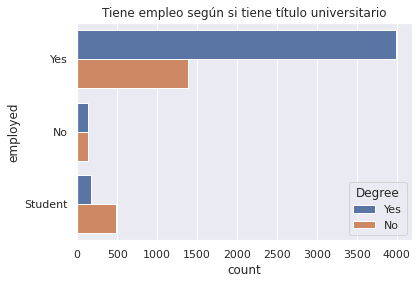

In [ ]:
sns.countplot(hue=df_employment.Degree, y=df_employment.employed)
plt.title('Tiene empleo según si tiene título universitario')
plt.show()

In [ ]:
# Chisquare test
x = df_employment.groupby(['Degree', 'employed'])['Degree'].count().values.reshape(2,3)
stats.chisquare(x)

Power_divergenceResult(statistic=array([1.34328358e-01, 1.48390244e+02, 1.26539732e+03]), pvalue=array([7.13985796e-001, 3.89786126e-034, 3.74065418e-277]))

In [ ]:
# Relation
c = df_employment.groupby(['Degree', 'employed'])['Degree'].count()
print(f'CON TÍTULO relación empleo/desempleo: {round(c[5]/c[3],2)} empleados por cada 1 desempleado ({round(c[3]/c[5]*100,2)}% de desempleo)')
print(f'SIN TÍTULO relación empleo/desempleo: {round(c[2]/c[0],2)} empleados por cada 1 desempleado ({round(c[0]/c[2]*100,2)}% de desempleo)')

CON TÍTULO relación empleo/desempleo: 30.45 empleados por cada 1 desempleado (3.28% de desempleo)
SIN TÍTULO relación empleo/desempleo: 10.09 empleados por cada 1 desempleado (9.91% de desempleo)


**Se rechaza Ho**. Es más probable conseguir empleo teniendo título.

### 2. ¿Si tengo título gano más que si no?

- **Hipótesis nula (Ho):** los salarios _son los mismos_ para personas con o sin título.
- **Hipótesis alternativa (Ha):** los salarios son _más altos_ para personas con título.

In [ ]:


s_has_degree = _deepnote_execute_sql("""select "ConvertedCompYearly"
from survey_s_2021
where "Degree" = 'Yes';
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
s_has_degree

,ConvertedCompYearly
0,46482.0
1,NaN
2,60480.0
3,58373.0
4,21620.0
...,...
4287,27492.0
4288,68721.0
4289,41232.0
4290,18326.0


In [ ]:


s_non_degree = _deepnote_execute_sql("""select "ConvertedCompYearly"
from survey_s_2021
where "Degree" = 'No';
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
s_non_degree

,ConvertedCompYearly
0,75000.0
1,8796.0
2,20539.0
3,NaN
4,16215.0
...,...
1998,NaN
1999,8244.0
2000,NaN
2001,24000.0


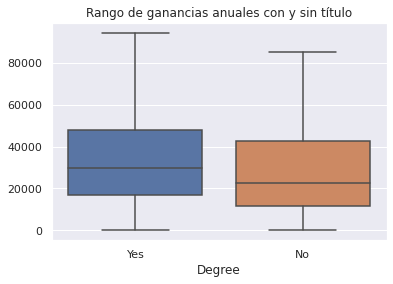

In [ ]:
sns.boxplot(x=df.Degree, y=df.ConvertedCompYearly, showfliers=False)
plt.title('Rango de ganancias anuales con y sin título')
plt.ylabel(None)
plt.show()

In [ ]:
# Test if has a normal distribution
print(stats.shapiro(s_has_degree.notnull()))
print(stats.shapiro(s_non_degree.notnull()))

ShapiroResult(statistic=0.5208181142807007, pvalue=0.0)
ShapiroResult(statistic=0.6341419816017151, pvalue=0.0)


El test de `shapiro` confirma que las distribuciones de los salarios no son normales, no se puede aplicar `stats.ttest_ind`. En cambio, se aplica `hypothesize.pb2gen` que usa bootstrap.

Este resultado se tomará en cuenta para el resto de análisis que requiera usar los salarios.

In [ ]:
pb2gen(s_has_degree, s_non_degree, trim_mean, .2)

{'est_1': 31090.308467741936,
 'est_2': 24916.923312883435,
 'est_dif': 6173.385154858501,
 'ci': [4393.396738323765, 7942.947088981793],
 'p_value': 0.0,
 'variance': 809098.6615641174,
 'n1': 3304,
 'n2': 1084}

**Se rechaza Ho.** Las personas con título tienden a ganar más anualmente. Dichas ganancias pueden ser de 4k a 7k extra al año. 

### 3. Si se aprende código únicamente de manera NO tradicional, ¿se gana menos?

- **Hipótesis nula (Ho):** los salarios _son los mismos_ para personas que aprendieron código de manera tradicional y no tradicional.
- **Hipótesis alternativa (Ha):** los salarios son _más bajos_ para personas que aprendieron código de manera NO tradicional.

In [ ]:


traditional = _deepnote_execute_sql("""select "ConvertedCompYearly"
from survey_s_2021
where "LearnCode" = 'Traditional';
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
traditional

,ConvertedCompYearly
0,58373.0
1,21600.0
2,8796.0
3,19860.0
4,96204.0
...,...
606,NaN
607,94250.0
608,68721.0
609,41232.0


In [ ]:


non_traditional = _deepnote_execute_sql("""select "ConvertedCompYearly"
from survey_s_2021
where "LearnCode" = 'Non-traditional';
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
non_traditional

,ConvertedCompYearly
0,NaN
1,60480.0
2,21620.0
3,22584.0
4,NaN
...,...
3219,21444.0
3220,5772.0
3221,NaN
3222,30108.0


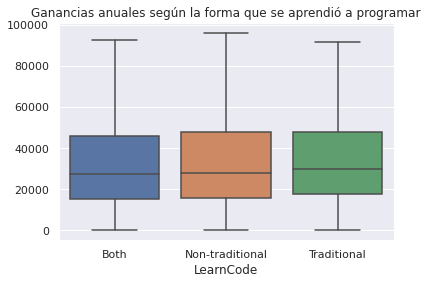

In [ ]:
sns.boxplot(x=df.LearnCode, y=df.ConvertedCompYearly, showfliers=False)
plt.title('Ganancias anuales según la forma que se aprendió a programar')
plt.ylabel(None)
plt.show()

In [ ]:
pb2gen(non_traditional, traditional, trim_mean, 0.2, nboot=10000)

{'est_1': 29769.08839354343,
 'est_2': 31161.80149812734,
 'est_dif': -1392.7131045839124,
 'ci': [-3909.7534049002934, 1068.9904135971483],
 'p_value': 0.2682,
 'variance': 1600886.613315168,
 'n1': 2167,
 'n2': 445}

Con un p-value > 0.01 **NO se rechaza Ho**. Es probable que la pequeña diferencia que se ve en la gráfica que haya dado por azar, no se puede asegurar que se gana menos si se aprende código únicamente de manera no-tradicional.

### 4. ¿Toma el mismo tiempo aprender a programar profesionalmente se tenga título o no?

- **Hipótesis nula (Ho):** toma el mismo aprender a programar se tenga título o no.
- **Hipótesis alternativa (Ha):** si se tiene título, tomó más tiempo aprender a programar.

In [ ]:


has_degree = _deepnote_execute_sql("""select "YearsLearnPro"
from survey_s_2021
where "Degree" = 'Yes';
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
has_degree

,YearsLearnPro
0,7.0
1,3.0
2,7.0
3,10.0
4,NaN
...,...
4287,3.0
4288,2.0
4289,5.0
4290,4.0


In [ ]:


non_degree = _deepnote_execute_sql("""select "YearsLearnPro"
from survey_s_2021
where "Degree" = 'No';
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
non_degree

,YearsLearnPro
0,4.5
1,0.0
2,4.0
3,NaN
4,4.0
...,...
1998,NaN
1999,2.5
2000,NaN
2001,3.0


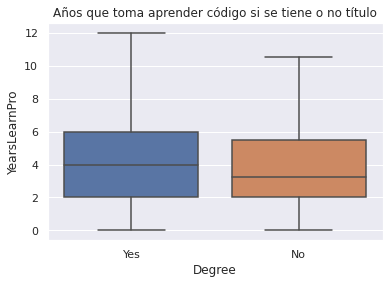

In [ ]:
sns.boxplot(x=df.Degree, y=df.YearsLearnPro, showfliers=False)
plt.title('Años que toma aprender código si se tiene o no título')
plt.show()

In [ ]:
pb2gen(has_degree, non_degree, trim_mean, 0.2, nboot=10000)

{'est_1': 4.303271631510977,
 'est_2': 3.5737597911227152,
 'est_dif': 0.7295118403882621,
 'ci': [0.5414500696295081, 0.9235837223181957],
 'p_value': 0.0,
 'variance': 0.00920894181672451,
 'n1': 3871,
 'n2': 1276}

**Se rechaza Ho**. Las personas con título tienden a tardar de 0.5 a 0.9 años más en aprender código que las que no.

### 5. ¿Toma menos tiempo aprender a programar profesionalmente si se aprende de forma NO tradicional?

- **Hipótesis nula (Ho):** toma el mismo aprender a programar sin importar si se lo hace de forma NO tradicional o no.
- **Hipótesis alternativa (Ha):** toma menos tiempo aprender a programar si se aprende de manera NO tradicional.

In [ ]:


traditional = _deepnote_execute_sql("""select "YearsLearnPro"
from survey_s_2021
where "LearnCode" = 'Traditional';
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
traditional

,YearsLearnPro
0,10.0
1,0.0
2,0.0
3,5.0
4,4.0
...,...
606,NaN
607,14.0
608,2.0
609,5.0


In [ ]:


non_traditional = _deepnote_execute_sql("""select "YearsLearnPro"
from survey_s_2021
where "LearnCode" = 'Non-traditional';
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
non_traditional

,YearsLearnPro
0,3.0
1,7.0
2,NaN
3,4.0
4,14.0
...,...
3219,3.5
3220,5.0
3221,1.0
3222,5.0


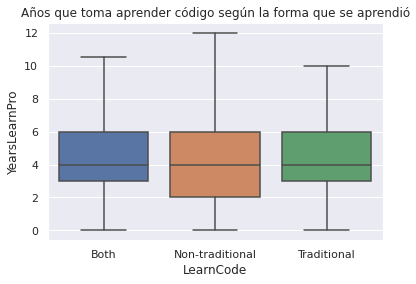

In [ ]:
sns.boxplot(x=df.LearnCode, y=df.YearsLearnPro, showfliers=False)
plt.title('Años que toma aprender código según la forma que se aprendió')
plt.show()

In [ ]:
pb2gen(non_traditional, traditional, trim_mean, 0.2, nboot=10000)

{'est_1': 3.887768379960963,
 'est_2': 4.387820512820513,
 'est_dif': -0.5000521328595497,
 'ci': [-0.7712139032080474, -0.24205599486178553],
 'p_value': 0.00019999999999997797,
 'variance': 0.018744292597685463,
 'n1': 2561,
 'n2': 518}

**Se rechaza Ho**. Si se aprende de forma NO tradicional se puede llegar a ser profesional de `0.2` a `0.7` años más pronto.

## Inclusión

### 6. ¿Los hombres ganan lo mismo que las mujeres?

- Hipótesis nula (Ho): los salarios son los mismos para hombres y mujeres.
- Hipótesis alternativa (Ha): los salarios son más altos para los hombres.

In [ ]:


man = _deepnote_execute_sql("""select "ConvertedCompYearly"
from survey_s_2021
where "Gender" = 'Man';
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
man

,ConvertedCompYearly
0,46482.0
1,NaN
2,60480.0
3,58373.0
4,21620.0
...,...
5833,27492.0
5834,68721.0
5835,41232.0
5836,18326.0


In [ ]:


woman = _deepnote_execute_sql("""select "ConvertedCompYearly"
from survey_s_2021
where "Gender" = 'Woman';
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
woman

,ConvertedCompYearly
0,18326.0
1,26796.0
2,6432.0
3,60000.0
4,NaN
...,...
244,38880.0
245,NaN
246,NaN
247,94250.0


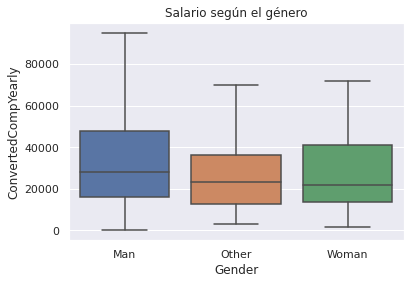

In [ ]:
sns.boxplot(x=df.Gender, y=df.ConvertedCompYearly, showfliers=False)
plt.title('Salario según el género')
plt.show()

In [ ]:
pb2gen(man, woman, trim_mean, 0.2, nboot=10000)

{'est_1': 30000.73607748184,
 'est_2': 24399.78,
 'est_dif': 5600.956077481842,
 'ci': [1944.157530266344, 8812.90072639225],
 'p_value': 0.0038,
 'variance': 3076156.6168183046,
 'n1': 4128,
 'n2': 164}

**Se rechaza Ho**. Los salarios de los hombres son más altos que los de las mujeres. El rango puede ser de 2k a 8k extra al año.

### 7. ¿Los héteros ganan más que los que no lo son?

- Hipótesis nula (Ho): los salarios son los mismos para todas las personas.
- Hipótesis alternativa (Ha): los salarios son más altos para los heteros.

In [ ]:


hetero = _deepnote_execute_sql("""select "ConvertedCompYearly"
from survey_s_2021
where "Sexuality" = 'Straight / Heterosexual'
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
hetero

,ConvertedCompYearly
0,46482.0
1,NaN
2,60480.0
3,58373.0
4,21620.0
...,...
5047,27492.0
5048,68721.0
5049,41232.0
5050,18326.0


In [ ]:


non_hetero = _deepnote_execute_sql("""select "ConvertedCompYearly"
from survey_s_2021
where "Sexuality" = 'LGBT / Non-hetero'
""", 'SQL_A62A6E90_C1CD_42A3_9ACA_116732175B05')
non_hetero

,ConvertedCompYearly
0,12972.0
1,NaN
2,17352.0
3,64859.0
4,NaN
...,...
1238,81682.0
1239,26112.0
1240,NaN
1241,NaN


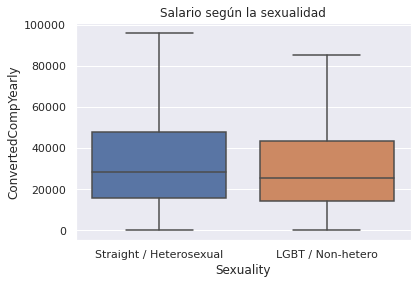

In [ ]:
sns.boxplot(x=df.Sexuality, y=df.ConvertedCompYearly, showfliers=False)
plt.title('Salario según la sexualidad')
plt.show()

In [ ]:
pb2gen(hetero, non_hetero, trim_mean, 0.2, nboot=10000)

{'est_1': 30192.351523419737,
 'est_2': 26890.55172413793,
 'est_dif': 3301.7997992818055,
 'ci': [1300.179263301503, 5182.357592008906],
 'p_value': 0.001,
 'variance': 970241.6408199997,
 'n1': 3665,
 'n2': 723}

**Se rechaza Ho.** Los heteros ganan más que los no heteros. El rango puede ser de 1k a 5k extra al año.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=09491c61-3767-4289-98fd-88aee19bb45d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>